In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 80% !important; }</style>"))

In [3]:
##### 대신증권 연결 확인
import win32com.client

instCpCybos = win32com.client.Dispatch("CpUtil.CpCybos")
print(instCpCybos.IsConnect)

from Tools import get_code, get_name

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from sklearn.preprocessing import minmax_scale
from statsmodels.tsa.stattools import coint
today = datetime.today().strftime("%Y%m%d") 

1


In [41]:
class Backtest():
    
    def __init__(self,code1,code2):
        
        self.today = datetime.today().strftime("%Y%m%d")
        self.code_1 = code1
        self.code_2 = code2   
        self.name_1 = get_name(code1)
        self.name_2 = get_name(code2)

 # 분 차트 받아오기
    def get_data(self,code,day):  # 종목, 기간, 오늘, 시점, 분, 시간간격
        
        today = self.today
        start = (datetime.today() - timedelta(day)).strftime("%Y%m%d") 
        
        temp = {}

        instStockChart = win32com.client.Dispatch("CpSysDib.StockChart")
        instStockChart.SetInputValue(0, code )
        instStockChart.SetInputValue(1, ord('1'))
        instStockChart.SetInputValue(2, today)
        instStockChart.SetInputValue(3, start)
        # instStockChart.SetInputValue(4, 1000)
        instStockChart.SetInputValue(5, (0,1,5))
        instStockChart.SetInputValue(6, ord('m'))  # 'D':일 'm' : 분, 'T' : 틱
        instStockChart.SetInputValue(7, 1)      # 데이터 주기
        instStockChart.SetInputValue(9, ord('1'))
        instStockChart.SetInputValue(10, 3)

        instStockChart.BlockRequest()

        numData = instStockChart.GetHeaderValue(3)
        numField = instStockChart.GetHeaderValue(1) 

        for i in range(numData):
            temp[str(instStockChart.GetDataValue(0, i)) +'.'+ str(instStockChart.GetDataValue(1, i))] = [instStockChart.GetDataValue(2, i)]
        temp = pd.DataFrame(temp).transpose()
        temp.index.names = ['time']
        
        return temp[::-1]


    def check_pvalue(self,from_,to_):     

        pvalues = {}
        for day in range(from_,to_):
        
            stock_1 = np.log(self.get_data(self.code_1,day)) 
            stock_2 = np.log(self.get_data(self.code_2,day))

            temp =  pd.merge(left = stock_1 , right = stock_2, how = "inner", on = "time")
            temp.columns = [str(day)+str(1),str(day)+str(2) ]

            score, pvalue, _ = coint(temp[str(day)+str(1)], temp[str(day)+str(2)])
            pvalues[pvalue] = day
            
            temp = pd.DataFrame()
        
        pvalue = max(pvalues.keys())
        best = pvalues[pvalue]
        print(pvalue)
        if  pvalue < 0.05:
            return pvalue
        if pvalue  > 0.05:
            print('p_value 값이 0.05보다 큼',pvalue)

    def hedge_ratio(self,hedge_ratio_1,hedge_ratio_2):
        
        self.hedge_ratio_1 = hedge_ratio_1
        self.hedge_ratio_2 = hedge_ratio_2
        
        
    def get_dataset(self,window_short,window_long,day,test_day):

        self.stock_1 = self.get_data(self.code_1,day) 
        self.stock_2 = self.get_data(self.code_2,day) 

        df =  pd.merge(left = self.stock_1 , right = self.stock_2, how = "inner", on = "time")
        df.columns = [self.name_1, self.name_2]        
        df['spread'] = df[self.name_1] * self.hedge_ratio_1- df[self.name_2]* self.hedge_ratio_2
        spread_short = df['spread'].rolling(window=window_short, center=False).mean()
        spread_long = df['spread'].rolling(window=window_long,center=False).mean()
        std_long = df['spread'].rolling(window=window_long,center=False).std()
        zscore = pd.DataFrame((spread_short - spread_long)/std_long) ; zscore.columns = ['zscore']
        zscore.dropna(inplace = True) 
        df =  pd.merge(left = df , right = zscore, how = "inner", on = "time")
        
        split = np.where(np.array(df.index)> str(test_day))[0][0]
        self.df_train = df.iloc[:split]
        self.df_test  = df.iloc[split:]
        
        score, pvalue, _ = coint(np.log(self.df_train[self.name_1]),np.log(self.df_train[self.name_2]))
        print('time interval : ',day,' , ','Cointegration test p-value: ' + str(pvalue))
        print(self.df_train.corr(method='pearson'))        
        
        self.df = df
        self.S1_train = self.df_train[self.name_1]
        self.S2_train = self.df_train[self.name_2]
        self.S1_test = self.df_test[self.name_1]
        self.S2_test = self.df_test[self.name_2]
        self.zscore_train = self.df_train['zscore']
        self.zscore_test = self.df_test['zscore']
        self.time_train = self.df_train.index
        self.time_test = self.df_test.index
    
    def threshold(self,threshold):
        
        self.threshold = threshold

        
    #Trade using a simple strategy
    def trade(self, train, money, window_short, window_long):
        
        if train == 'train':
            S1 = self.S1_train
            S2 = self.S2_train
            zscore = self.zscore_train
            time = self.time_train
        elif train == 'test':
            S1 = self.S1_test
            S2 = self.S2_test    
            zscore = self.zscore_test
            time = self.time_test

        hedge_ratio_1 = self.hedge_ratio_1
        hedge_ratio_2 = self.hedge_ratio_2

        fee_16_buy = (1.00015)
        fee_16_sell= (1-0.00015)
        fee_49_buy = (1.00015)
        fee_49_sell= (1-0.00015)

        cash = money
        
        threshold = self. threshold
        
        # If window length is 0, algorithm doesn't make sense, so exit
        if (window_short == 0) or (window_long == 0):
            return 0

        # Simulate trading

        # Start with no money and no positions        
        count_S1 = 0 
        count_S2 = 0     

        for i in range(len(zscore)):        
            print(i+1,'번째거래')

            # Sell short if the z-score is > 1
            if zscore[i] > threshold:   # sell S1  buy S2
                if cash < min(S1[i],S2[i]) :
                    continue  

                count_S1 -= hedge_ratio_1
                count_S2 += hedge_ratio_2

                cash +=  S1[i] * hedge_ratio_1 * fee_49_sell - S2[i] * hedge_ratio_2 * fee_49_buy

                eval_S1 = count_S1 * S1[i] 
                eval_S2 = count_S2 * S2[i] 
                eval_total = abs(eval_S1) + abs(eval_S2)

                if eval_total <= 400000 :
                    eval_total = eval_S1*fee_49_buy + eval_S2 * fee_49_sell
                else :
                    eval_total = eval_S1*fee_16_buy + eval_S2 * fee_16_sell 
                print( '[',time[i],']-----------',self.name_1,'현재가 :',S1[i],' / ',self.name_2,'현재가 :',S2[i], '  /  zscore :',zscore[i])
                print('[SELL_INFO]  ',self.name_1,'매도금액 :',S1[i]* hedge_ratio_1*fee_49_sell,'/ ',self.name_2,'매수금액 :',S2[i]*hedge_ratio_2* fee_49_buy,
                      str(self.name_1),':',count_S1,'주  /  ',str(self.name_2),':',count_S2,'주')
                print('[SELL]' ,'잔고: ',round(eval_total + cash,2),'원  ', ' / 평가금액 :',eval_total,'/ 예수금 :',cash )

            # Buy long if the z-score is < 1
            elif zscore[i] < -threshold: # buy kospi sell kosdaq
                if cash < min(S1[i],S2[i]) :
                    continue              

                count_S1 += hedge_ratio_1
                count_S2 -= hedge_ratio_2

                cash += - S1[i] * hedge_ratio_1 * fee_49_buy + S2[i] * hedge_ratio_2 * fee_49_sell

                eval_S1 = count_S1 * S1[i] 
                eval_S2 = count_S2 * S2[i] 
                eval_total = abs(eval_S1) + abs(eval_S2)

                if eval_total <= 400000 :
                    eval_total = eval_S1*fee_49_sell + eval_S2 * fee_49_buy
                else :
                    eval_total = eval_S1*fee_16_sell + eval_S2 * fee_16_buy         

                print( '[',time[i],']-----------',self.name_1,'현재가 :',S1[i],' / ',self.name_2,'현재가 :',S2[i], '  /  zscore :',zscore[i])
                print('[BUY_INFO]  ',self.name_1,'매수금액 :',S1[i]*hedge_ratio_1* fee_49_buy,'/ ',self.name_2,'매도금액 :',S2[i]*hedge_ratio_2* fee_49_sell,
                      str(self.name_1),':',count_S1,'주  /  ',str(self.name_2),':',count_S2,'주')
                print('[BUY]' ,'잔고: ',round(eval_total + cash,2),'원  ',' / 평가금액 :',eval_total,'/ 예수금 :',cash )


            # Clear positions if the z-score between -.5 and .5        
            # -0.5~0.5 사이인 경우 수익일 경우 이익 실현
            elif abs(zscore[i]) < threshold :           

                eval_S1 = count_S1 * S1[i] 
                eval_S2 = count_S2 * S2[i] 
                eval_total = abs(eval_S1) + abs(eval_S2)

                if eval_total <= 400000 :
                    if count_S1 > 0 :                   
                        temp_cash = cash + eval_S1*fee_49_sell + eval_S2 * fee_49_buy 
                        if temp_cash > money :
                            cash = temp_cash
                            count_S1 = 0 
                            count_S2 = 0 
                            print('[',time[i],']-----------',self.name_1,'현재가 :',S1[i],' / ',self.name_2,'현재가 :',S2[i])
                            print('[EXIT_INFO]' , '총매도금액 :',eval_S1*fee_49_sell,'원',' / 총매수금액 :', -eval_S2 *fee_49_buy ,'원')
                            print('[EXIT]' ,'잔고: ',round(cash,2),'원  ',str(self.name_1),':',count_S1,'주  /  ',str(self.name_2),':',count_S2,'주' ) 

                    elif count_S1 < 0:
                        temp_cash = cash - eval_S1*fee_49_buy - eval_S2 * fee_49_sell 
                        if eval_total + temp_cash > money :    
                            cash = temp_cash
                            count_S1 = 0 
                            count_S2 = 0 
                            print('[',time[i],']-----------',self.name_1,'현재가 :',S1[i],' / ',self.name_2,'현재가 :',S2[i])
                            print('[EXIT_INFO]' , '총매도금액 :',eval_S2 *fee_49_sell,'원',' / 총매수금액 :', -eval_S1 *fee_49_buy,'원',)
                            print('[EXIT]' ,'잔고: ',round(cash,2),'원  ',str(self.name_1),':',count_S1,'주  /  ',str(self.name_2),':',count_S2,'주' ) 

                    else:
                        pass  

                elif eval_total > 400000 :

                    if count_S1 > 0 :            
                        temp_cash = cash - count_S1 * S1[i]*fee_16_sell - count_S2 * S2[i]*fee_16_buy 
                        if eval_total + temp_cash > money :
                            cash = temp_cash
                            count_S1 = 0 
                            count_S2 = 0
                            print('[',time[i],']-----------',self.name_1,'현재가 :',S1[i],' / ',self.name_2,'현재가 :',S2[i])
                            print('[EXIT_INFO]' , '총매도금액 :',eval_S1*fee_16_sell - 700,'원',' / 총매수금액 :', -eval_S2 *fee_16_buy+700 ,'원')
                            print('[EXIT]' ,'잔고: ',round(cash,2),'원  ',str(self.name_1),':',count_S1,'주  /  ',str(self.name_2),':',count_S2,'주' )

                    elif count_S1 < 0:
                        temp_cash = cash - count_S1 * S1[i]*fee_16_buy - count_S2 * S2[i]*fee_16_sell 
                        if temp_cash > money :    
                            cash = temp_cash
                            count_S1 = 0 
                            count_S2 = 0
                            print('[',time[i],']-----------',self.name_1,'현재가 :',S1[i],' / ',self.name_2,'현재가 :',S2[i])
                            print('[EXIT_INFO]' , '총매도금액 :',eval_S2 *fee_16_sell - 700,'원',' / 총매수금액 :', -eval_S1 *fee_16_buy+700 ,'원',)
                            print('[EXIT]' ,'잔고: ',round(cash,2),'원  ',str(self.name_1),':',count_S1,'주  /  ',str(self.name_2),':',count_S2,'주' ) 

                    else:
                        pass                                  

        eval_S1 = count_S1 * S1[-1] 
        eval_S2 = count_S2 * S2[-1] 
        eval_total = abs(eval_S1) + abs(eval_S2)
        
        if count_S1>0:
            if eval_total <= 400000 :
                cash += eval_S1 * fee_49_sell + eval_S2 * fee_49_buy
            elif eval_total > 400000 :
                cash += eval_S1 * fee_16_sell + eval_S2 * fee_16_buy      
        elif count_S1>0:
            if eval_total <= 400000 :
                cash += eval_S1 * fee_49_buy + eval_S2 * fee_49_sell
            elif eval_total > 400000 :
                cash += eval_S1 * fee_16_buy + eval_S2 * fee_16_sell 
        else:
            pass
                            
        return cash    

# 분석

In [50]:
test = Backtest(get_code('삼성전자'),get_code('SK하이닉스'))
# test.check_pvalue(5,30)
test.hedge_ratio(5,3)
test.get_dataset(5,20,365,20201223)
# test.df[['삼성전자','SK하이닉스']]
test.threshold(1)

time interval :  365  ,  Cointegration test p-value: 0.6193633424295628
            삼성전자    SK하이닉스    spread    zscore
삼성전자    1.000000  0.929922 -0.700213  0.089908
SK하이닉스  0.929922  1.000000 -0.913698  0.065376
spread -0.700213 -0.913698  1.000000 -0.027562
zscore  0.089908  0.065376 -0.027562  1.000000


## 윈도우 사이즈 그리드 서치

In [1]:
# train
length_scores = {}
for window_short in range(1,20):
    for window in range(5,60):
        length_scores[test.trade('train',1000000, i, j)] = (i,j)
best_length = max(length_scores.keys())
# print ('Best window length:', length_scores[best_length])
print (best_length, 'day window:', length_scores[best_length])

# Test
# length_scores2 = {}
# for i in range(1,20):
#     for j in range(5,60):
#         length_scores2[test.trade('test',1000000, i, j)] = (i,j)
# best_length2 = max(length_scores2.keys())
# print (best_length2, 'day window:', length_scores2[best_length2])

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(length_scores)
plt.plot(length_scores2)
plt.xlabel('Window length')
plt.ylabel('Score')
plt.legend(['Training', 'Test'])
plt.show()

## 시뮬레이션

In [ ]:
test.trade('train',1000000, 1, 59)

## 백테스트

In [53]:
test.trade('test',2000000, 5, 20)

1 번째거래
2 번째거래
3 번째거래
4 번째거래
5 번째거래
6 번째거래
7 번째거래
8 번째거래
9 번째거래
10 번째거래
11 번째거래
12 번째거래
13 번째거래
14 번째거래
15 번째거래
16 번째거래
17 번째거래
18 번째거래
19 번째거래
20 번째거래
21 번째거래
22 번째거래
23 번째거래
24 번째거래
25 번째거래
26 번째거래
27 번째거래
28 번째거래
29 번째거래
30 번째거래
31 번째거래
[ 20201223.931 ]----------- 삼성전자 현재가 : 72900  /  SK하이닉스 현재가 : 115000   /  zscore : -1.4059363643203997
[BUY_INFO]   삼성전자 매수금액 : 364554.67500000005 /  SK하이닉스 매도금액 : 344948.25 삼성전자 : 5 주  /   SK하이닉스 : -3 주
[BUY] 잔고:  1999787.15 원    / 평가금액 : 19393.574999999953 / 예수금 : 1980393.575
32 번째거래
[ 20201223.932 ]----------- 삼성전자 현재가 : 72900  /  SK하이닉스 현재가 : 115000   /  zscore : -1.3829441491944365
[BUY_INFO]   삼성전자 매수금액 : 364554.67500000005 /  SK하이닉스 매도금액 : 344948.25 삼성전자 : 10 주  /   SK하이닉스 : -6 주
[BUY] 잔고:  1999574.3 원    / 평가금액 : 38787.14999999991 / 예수금 : 1960787.15
33 번째거래
[ 20201223.933 ]----------- 삼성전자 현재가 : 72900  /  SK하이닉스 현재가 : 114500   /  zscore : -1.1820325789975228
[BUY_INFO]   삼성전자 매수금액 : 364554.67500000005 /  SK하이닉스 매도금액 : 343448.475 삼성전자 : 15 주  /

2047503.2249999996

# -------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# #Trade using a simple strategy
# def trade(self, money, window_short, window_long):
    
#     S1 = self.stock_1
#     S2 = self.stock_2
    
#     hedge_ratio_1 = self.hedge_ratio_1
#     hedge_ratio_2 = self.hedge_ratio_2
    
#     # If window length is 0, algorithm doesn't make sense, so exit
#     if (window1 == 0) or (window2 == 0):
#         return 0

#     # Compute rolling mean and rolling standard deviation
#     zscore = self.get_zscore(window_short, window_long)
#     # Simulate trading
    
#     # Start with no money and no positions        
#     count_S1 = 0 ; temp1 = count_S1  #13
#     count_S2 = 0 ; temp2 = count_S2  #42
    

#     for i in range(len(zscore)):        
#         print(i+1,'번째 거래')
    
#         # Sell short if the z-score is > 1
#         if zscore[i] > 1:   # sell kospi  buy kosdaq

#             count_S1 -= hedge_ratio_1
#             count_S2 += hedge_ratio_2
            
#             buy_amount_S1.append(-S1[i]*hedge_ratio_1)
#             buy_amount_S2.append(S2[i] * hedge_ratio_2 * (1.004936563)) ; bookprice_S2 = sum(buy_amount_S2) / count_S2
#             buy_amount_total = sum(buy_amount_S1) + sum(buy_amount_S2)
            
#             cash +=  S1[i] *hedge_ratio_1* (1-0.004936563) - S2[i] * hedge_ratio_2 * (1.004936563)
            
#             eval_S1 = count_S1 * S1[i] * (1-0.001636563) - 700
#             eval_S2 = count_S2 * S2[i] * (1-0.001636563) - 700
#             eval_total = eval_S1 + eval_S2

#             balance = eval_total + cash
#             print('----',S1[i],S2[i])
#             print('bookprice' , bookprice_S1, bookprice_S2)
#             print('[SELL_INFO]',' kospi매도금액 :',S1[i]* hedge_ratio_1*(1-0.004936563),'/ kosdaq매수금액 :',S2[i]*hedge_ratio_2* (1.004936563))
#             print('[SELL]' ,'잔고: ',round(balance,2),'원', 'kospi :',count_S1,'주  /  kosdaq:',count_S2,'주' )
          
#         # Buy long if the z-score is < 1
#         elif zscore[i] < -1: # buy kospi sell kosdaq
                        
#             count_S1 += hedge_ratio_1
#             count_S2 -= hedge_ratio_2
            
#             buy_amount_S1.append(S1[i]*hedge_ratio_1* (1.004936563)) ; bookprice_S1 = sum(buy_amount_S1) / count_S1
#             buy_amount_S2.append(-bookprice_S2) 
#             buy_amount_total = sum(buy_amount_S1) + sum(buy_amount_S2)

#             cash +=  - S1[i] * hedge_ratio_1 * (1.004936563) + S2[i] * hedge_ratio_2 * (1-0.004936563)
            
#             eval_S1 = count_S1 * S1[i] * (1-0.001636563) - 700
#             eval_S2 = count_S2 * S2[i] * (1-0.001636563) - 700
#             eval_total = eval_S1 + eval_S2

#             balance = eval_total + cash
#             print('----',S1[i],S2[i])
#             print('bookprice' , bookprice_S1, bookprice_S2)
#             print('[BUY_INFO]',' kospi매수금액 :',S1[i]*hedge_ratio_1* (1.004936563),'/ kosdaq매도금액 :',S2[i]*hedge_ratio_2* (1-0.004936563))
#             print('[BUY]' ,'잔고: ',round(balance,2),'원','kospi :',count_S1,'주  /  kosdaq:',count_S2,'주' )

            
#         # Clear positions if the z-score between -.5 and .5        
#         # -0.5~0.5 사이인 경우 수익일 경우 이익 실현
#         elif abs(zscore[i]) < 0.5 :           
            
#             eval_S1 = count_S1 * S1[i] * (1-0.001636563) - 700
#             eval_S2 = count_S2 * S2[i] * (1-0.001636563) - 700
#             eval_total = eval_S1 + eval_S2
            
#             if (abs(S1[i]*(count_S1-temp1)) + abs(S2[i] * (count_S2-temp2))) >=400000 :                
#                 temp_cash = cash + (count_S1-temp1) * S1[i]*(1-0.001636563) - 700 - ( (temp2-count_S2) * S2[i]*(1.001636563)+700 )

#                 if eval_total + temp_cash > money :                
#                     if count_S1 > 13 :                    

#                         buy_amount_S1.append( -(count_S1-temp1) * bookprice_S1)
#                         buy_amount_S2.append( (temp2-count_S2) * S2[i]*(1.001636563)+700 ) ; bookprice_S2 = sum(buy_amount_S2) / temp2
#                         buy_amount_total = sum(buy_amount_S1) + sum(buy_amount_S2)

#                         cash +=  (count_S1-temp1) * S1[i]*(1-0.001636563) - 700 - ( (temp2-count_S2) * S2[i]*(1.001636563)+700 )

#                         print('[EXIT_INFO]' , '총매도금액 :',(count_S1-temp1) * S1[i]*(1-0.001636563) - 700,'원',' / 총매수금액 :', (temp2-count_S2) * S2[i]*(1.001636563)+700 ,'원',)

#                     elif count_S1 < 13:

#                         buy_amount_S1.append(S1[i]* (1.004936563)) ; bookprice_S1 = sum(buy_amount_S1) / temp1
#                         buy_amount_S2.append(-bookprice_S2) 
#                         buy_amount_total = sum(buy_amount_S1) + sum(buy_amount_S2)

#                         cash +=  - S1[i] * (1.004936563) + S2[i] * hedge_ratio_2 * (1-0.004936563)
#                         print('[EXIT_INFO]' , '총매도금액 :',(count_S2-temp2) * S2[i]*(1-0.001636563)-700,'원',' / 총매수금액 :', (temp1-count_S1) * S1[i]*(1.001636563)+700 ,'원',)
#                     else:
#                         pass
                                    
#                     count_S1 = 0 ; temp1 = count_S1  #13
#                     count_S2 = 0 ; temp2 = count_S2  #42

#                     balance = eval_total + cash

#                     #print('Exit pos %s %s %s %s'%(money,ratios[i], count_S1,count_S2))
#                     print('[EXIT]' ,'balance: ',round(balance,2),'원',' 주식1매도수: ',count_S1,' 주식2매도수: ',count_S2 )                
            
#             if (abs(S1[i]*(count_S1-temp1)) + abs(S2[i] * (count_S2-temp2))) <400000 :
#                 temp_cash = cash + (count_S1-temp1) * S1[i]*(1-0.004936563) - ( (temp2-count_S2) * S2[i]*(1-0.004936563) )
#                 if eval_total + temp_cash > money :
#                     if count_S1 > temp1 :

#                         buy_amount_S1.append( -(count_S1-temp1) * bookprice_S1)
#                         buy_amount_S2.append( (temp2-count_S2) * S2[i]*(1-0.004936563) ) ; bookprice_S2 = sum(buy_amount_S2) / temp2
#                         buy_amount_total = sum(buy_amount_S1) + sum(buy_amount_S2)

#                         cash +=  (count_S1-temp1) * S1[i]*(1-0.004936563) - ( (temp2-count_S2) * S2[i]*(1-0.004936563) )
#                         print('[EXIT_INFO]' , '총매도금액 :',(count_S1-temp1) * S1[i]*(1-0.004936563),'원',' / 총매수금액 :',(temp2-count_S2) * S2[i] * (1.004936563),'원',)

#                     elif count_S1 < temp1 :

#                         buy_amount_S1.append(S1[i]* (1.004936563)) ; bookprice_S1 = sum(buy_amount_S1) / temp1
#                         buy_amount_S2.append(-bookprice_S2) 
#                         buy_amount_total = sum(buy_amount_S1) + sum(buy_amount_S2)

#                         cash +=  - S1[i] * (1.004936563) + S2[i] * 3 * (1-0.004936563)
#                         print('[EXIT_INFO]' , '총매도금액 :',(count_S2-temp2) * S2[i]*(1-0.004936563),'원',' / 총매수금액 :',-(count_S1-temp1) * S1[i]*(1-0.004936563),'원',)
#                     else:
#                         pass 
#                     count_S1 = 0 ; temp1 = count_S1  #13
#                     count_S2 = 0 ; temp2 = count_S2  #42

#                     balance = eval_total + cash

#                     print('[EXIT]' ,'balance: ',round(balance,2),'원',' 주식1매도수:',count_S1,' 주식2매도수: ',count_S2 )
                
#         if cash < 0 :
#             break        
#         balance = eval_total + cash
    
#     return balance 

In [53]:
for i in range(3,30):
    print(test.check_pvalue(i),i)

0.10329805807312664 3
0.0009858175082795243 4
0.4999030872515131 5
0.4999030872515131 6
0.4999030872515799 7
0.09023194926051409 8
0.6876785020448087 9
0.5611558122053786 10
0.2639984929956039 11
0.23194445185786028 12
0.23194445185790807 13
0.23194445185782492 14
0.6380740395836354 15
0.6264428135842542 16
0.6026342129412561 17
0.5193890076386274 18
0.47865682131601267 19


KeyboardInterrupt: 

In [47]:
a = test.df['신한지주']/test.df['신한지주'][0]
b = test.df['KB금융']/test.df['KB금융'][0]
# a = test.df['신한지주']
# b = test.df['KB금융']

Text(0.5,1,'Cummulative Plot of ')

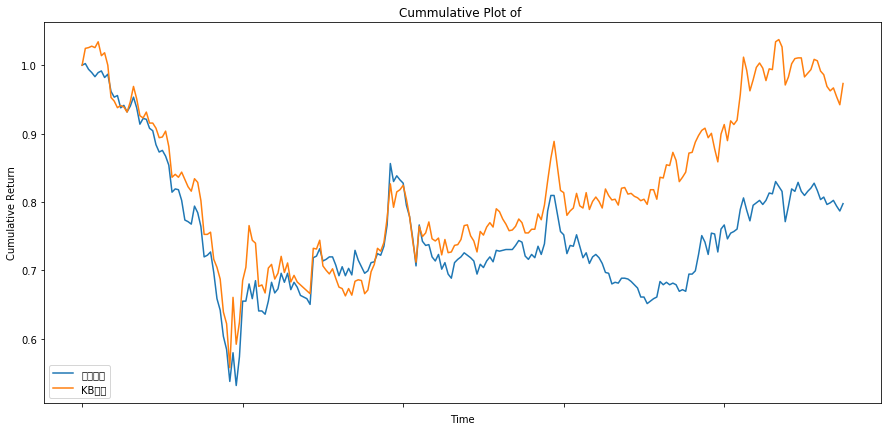

In [43]:
pd.concat([a, b], axis=1).plot(figsize=(15,7))
plt.ylabel('Cumulative Return');
plt.xlabel('Time');
title = 'Cummulative Plot of ' 
plt.title(title)